# Aufgabe 9: Klassifikation mit CNN
In unserer heutigen Aufgabe wollen wir kurze Film-Reviews mittels CNNs nach ihrer Polarität (subjective | objective) klassifizieren. 

Folgende Teilaufgaben werden wir bearbeiten:
1. Preprocessing Pipeline
2. Daten verstehen und vorbereiten
3. CNN modellieren, trainieren, evaluieren
4. Visuelle Darstellung der Ergebnisse


#### Module

In [2]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.layers import Input, Embedding, Dropout, Dense
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, GlobalMaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

#### Farben definieren

In [3]:
# Colours
plot_rost = (236 / 255., 116 / 255., 5 / 255.)
plot_blue = (31 / 255., 119 / 255., 180 / 255.)
plot_green = (103 / 255., 191 / 255., 92 / 255.)
plot_grey = (207 / 255., 207 / 255., 207 / 255.)

### 1. Preprocessing Pipeline
Wenn Sie den Datensatz anschauen, wird Ihnen auffallen, dass dieser schon lowercased und tokenisiert ist. 
Nichtsdestotrotz können wir noch weitere Bereinigungen vornehmen:
- HTML-Tags entfernen (BeautifulSoup)
- Kontraktionen expandieren
- Stoppwörter (außer Negation) entfernen
- Sonstige unerwünschte Character entfernen

In [4]:
# Stopwort-Liste laden und Negation entfernen
stop_words = set(stopwords.words('english'))
stop_words.remove('no')
stop_words.remove('not')

In [5]:
# Kontraktionen exandieren -> Negation
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"shan\'t", "shall not", phrase)
    
    # general
    phrase = re.sub(r"n\'t ", " not ", phrase)
    phrase = re.sub(r"\'re ", " are ", phrase)
    phrase = re.sub(r"\'s ", " is ", phrase)
    phrase = re.sub(r"\'d ", " would ", phrase)
    phrase = re.sub(r"\'ll ", " will ", phrase)
    phrase = re.sub(r"\'t ", " not ", phrase)
    phrase = re.sub(r"\'ve ", " have ", phrase)
    phrase = re.sub(r"\'m ", " am ", phrase)
    return phrase


In [6]:
# Normalisation
def preprocess_pipe(text):
    # HTML
    new_string = BeautifulSoup(text, "lxml").text
    # contractions
    new_string = decontracted(new_string)
    # Stop Words
    new_string = ' '.join(token for token in new_string.split() if token not in stop_words)
    # remove everything not character, digit or whitespace
    new_string = re.sub(r'[^a-zA-Z0-9\s]', '', new_string)
    # remove multiple whitespaces
    new_string = re.sub(r' +', ' ', new_string)
    # 'tokenize' by whitespace
    new_string = new_string.split()
    
    return ' '.join(new_string)

#### Daten einlesen und bereinigen
Einesen der Datei *Sentence-Polarity-Corpus.csv* mit Hilfe von pandas *read_csv*-Funktion. 

In [7]:
# Load dataset 
dataset = pd.read_csv('./Sentence-Polarity-Corpus.txt')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10662 entries, 0 to 10661
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  10662 non-null  object
 1   Label   10662 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 166.7+ KB


In [8]:
# Call preprocessing pipeline    
dataset['CleanReview'] = dataset['Review'].apply(preprocess_pipe)


c:\Users\jonas\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10662 entries, 0 to 10661
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review       10662 non-null  object
 1   Label        10662 non-null  int64 
 2   CleanReview  10662 non-null  object
dtypes: int64(1), object(2)
memory usage: 250.0+ KB


### 2. Daten verstehen und vorbereiten
a) Visualisierung der Verteilung der Review-Längen

b) Vectorizer erstellen


#### a) Plot Distribution
Grafik, deren X-Achse die Länge der Reviews anzeigt und deren Y-Achse die Frequenz dieser Längen anzeigt. Anhand dieser Grafik können wir bestimmen, wie lang unsere Sequenzen sind (Pad Sequences). 


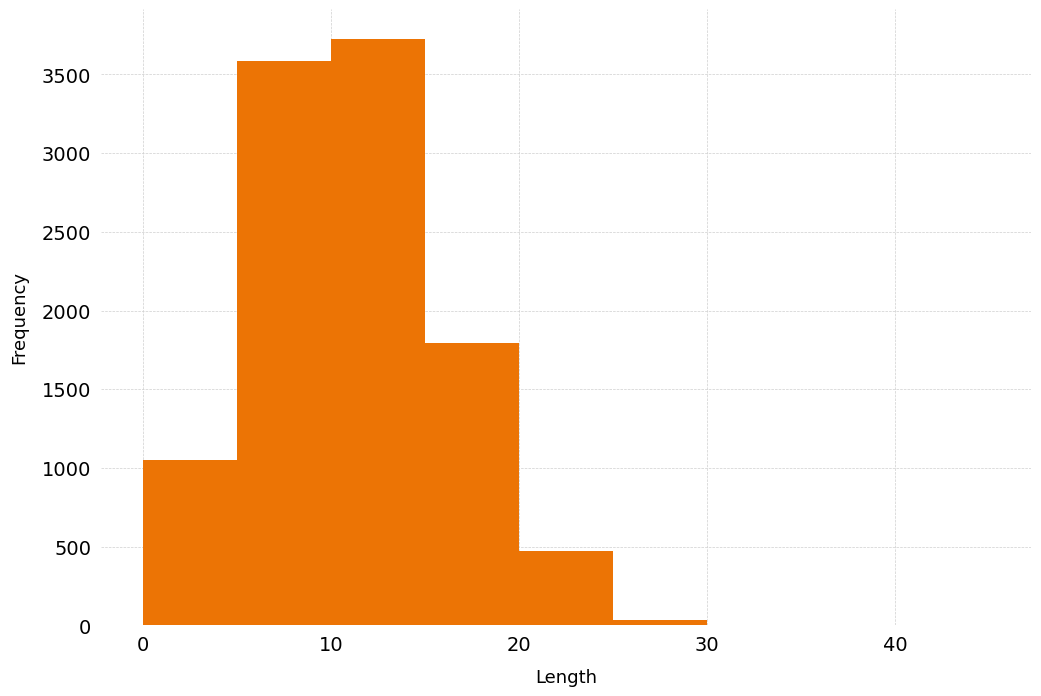

In [10]:
# Plot Distribution
reviews_length = [len(comment.split()) for comment in dataset['CleanReview']]
plt.figure(figsize=(12,8))
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)
plt.hist(reviews_length, bins = np.arange(0,50,5), zorder=3, color=plot_rost) 
plt.xlabel('Length', fontsize=13, labelpad=10)
plt.ylabel('Frequency', fontsize=13, labelpad=10)
plt.grid(zorder=0, linewidth=0.5, linestyle='--', color=plot_grey)
plt.tick_params(axis="both", bottom=False, left=False)
plt.box(on=None)
#plt.savefig('./SentencePolarity_review_length.png', dpi=500, transparent=False, bbox_inches='tight')
plt.show()

#### Vectorizer erstellen
- *Tokenizer()* auf unsere Spalte *CleanReview* anwenden
- Anzahl der Unique Tokens anzeigen
- Mit dieser Anzahl den Tokenizer mit *max_features* erstellen
- Token anwenden um Text in Sequenzen umzuwandeln

In [11]:
# Tokenizer without restriction
tokenizer = Tokenizer()
# Tokenizer fitten 
tokenizer.fit_on_texts(dataset['CleanReview'])

# Length of vocabulary
word_index = tokenizer.word_index
print('Unique Tokens: {}'.format(len(word_index)))


Unique Tokens: 19874


In [12]:
# maximal numbers of features
max_features = 15000

# Tokenizer mit num_words = max_features
tokenizer = Tokenizer(num_words=max_features)
# Tokenizer fitten 
tokenizer.fit_on_texts(dataset['CleanReview'])

# Tokenizer anwenden
sequences = tokenizer.texts_to_sequences(dataset['CleanReview'])

print(sequences[1])
print(sequences[10])

[10019, 3, 10020, 569, 279, 3670, 3671, 1508]
[2403, 4380, 10024, 409, 1292, 10025, 6968, 572, 2723, 10026]


#### Pad Sequences
Jede Instanz muss die gleiche Länge aufweisen, daher muss eine maximale Sequenzlänge festgelegt werden. Kürzere Reviews werden zu dieser Länge aufgefüllt, längere Reviews werden auf diese Länge gekürzt. 

Wie in der oben erstellten Grafik zu sehen ist, hat das längste Review 30 Wörter (nach Bereinigung). Dies ist kurz genug, um keine Reviews kürzen zu müssen. Daher legen wir diesen Wert als *max_length* fest und füllen kürzere Reviews bis zu dieser Länge auf. 

In [13]:
# max_length festlegen
max_length = 30

X = pad_sequences(sequences, maxlen=max_length)


#### Labels

In [14]:
# Convert labels to array
y = np.asarray(dataset['Label'])

# Print shapes
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)


Shape of data tensor: (10662, 30)
Shape of label tensor: (10662,)


#### Pre-trained Word Embeddings 
Heute nutzen wir die pre-trained word vectors aus *wiki-news-300d-1M.vec* von fastText ([Download](https://fasttext.cc/docs/en/english-vectors.html)). 

**Hinweis:** Folgender Code ist zur Verarbeitung verschiedener Embeddings (GloVe, word2vec, ...) geeignet, solange der Input im sog. word2vec-Format ist (jede Zeile beginnt mit einem Wort gefolgt von seinen Vektoren; jeder Wert ist mit Space getrennt). 

In [15]:
%%time
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('./wiki-news-300d-1M.vec')

embedding_dim = 300
vocabulary_size = min(len(word_index)+1, max_features)
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

for word, i in word_index.items():
    if i >= max_features:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = word_vectors['unk']


Wall time: 2min 47s


### 4. CNN

#### CNN modellieren
Das CNN definieren wir ähnlich wie [Zhang & Wallace](https://www.aclweb.org/anthology/I17-1026.pdf):

- input word vector: fastText
- filter region size: (3, 4, 5)
- feature maps: 100
- activation function: ReLU
- pooling: GlobalMaxPooling1D
- dropout rate: 0.5
- output: sigmoid

Erläuterung von [conv1d](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) (für die Erläuterung der anderen Funktionen siehe Sidebar links).

In [16]:
def cnn_model():
    
    # Input Layer
    input_layer = Input(shape=(max_length, ), dtype='int64')
    
    # Embedding Layer mit Gewichten aus der embedding_matrix
    embedding_layer = Embedding(max_features, embedding_dim, input_length=max_length, 
                                weights=[embedding_matrix])(input_layer)
    
    # Generate Convolutional Layers
    conv_layers = list()
    kernels = [3,4,5]
    for kernel in kernels:
        conv1d = Conv1D(100, kernel_size=kernel, padding='same', activation='relu')(embedding_layer)
        glbmax1d = GlobalMaxPooling1D()(conv1d)
        conv_layers.append(glbmax1d)
    
    # Concatenate
    conc_layer = concatenate(conv_layers, axis=1)
    
    # Fully Connected layer
    drop_1 = Dropout(0.5)(conc_layer)
    dense_1 = Dense(100)(drop_1)
    
    # Output Layer
    output_layer = Dense(1, activation='sigmoid')(dense_1)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Adam Optimizer
    adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    # Compile Model
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


#### Model Summary und Grafik

In [17]:
# Summary
model = cnn_model()
model.summary()

# Plot Model
plot_model(model, show_layer_names=False)
plot_model(model, show_shapes=True, show_layer_names=False)


ValueError: decay is deprecated in the new Keras optimizer, pleasecheck the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

#### Modell trainieren und evaluieren mit k-fold Cross-Validation

In [ ]:
seed = 1
# k-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

history_list = list()
evaluation_list = list()

for fold, [train, test] in enumerate(kfold.split(X, y)):
    
    # Load Model
    model = cnn_model()
    
    print('\n>>> Training | Fold {}'.format(fold+1))
    
    # Test
    X_test = X[test]
    y_test = y[test]
        
    # Callbacks
    path = './models/SentencePolarity_CNN_word_model_fold-{}.hdf5'.format(fold+1)
    checkpoint = ModelCheckpoint(path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=2)
    callbacks_list = [checkpoint]
    
    # Fit Model
    history = model.fit(X[train], y[train], validation_split=0.1,
                        epochs=10, batch_size=100, shuffle=True, callbacks=callbacks_list)
    
    # Append History
    history_list.append(history)

    # Load Best Model
    best_model = load_model(path)
    
    # Evaluate Model
    evaluation = best_model.evaluate(X_test, y_test)
    accuracy = round(evaluation[1], 3)
    loss = round(evaluation[0], 3)
    print('Accuracy: {} | Loss: {}\n'.format(accuracy, loss))
    
    # Precision, Recall, F1-Score
    y_values = best_model.predict(X_test)
    y_pred = [1 if y >= 0.5 else 0 for y in y_values]
    precision = round(precision_score(y_test, y_pred, average='binary'), 3)
    recall = round(recall_score(y_test, y_pred, average='binary'), 3)
    f1 = round(f1_score(y_test, y_pred, average='binary'), 3)
    print('Precision: {} | Recall: {} | F1-Score: {}'.format(precision, recall, f1))
    
    # Append Results
    evaluation_list.append([fold+1, accuracy, loss, precision, recall, f1])
    
    # Delete Model
    del model
    del history


>>> Training | Fold 1
Epoch 1/10
77/77 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.5559
Epoch 00001: val_accuracy improved from -inf to 0.71043, saving model to ./models/SentencePolarity_CNN_word_model_fold-1.hdf5
77/77 [==============================] - 6s 72ms/step - loss: 0.6871 - accuracy: 0.5559 - val_loss: 0.6376 - val_accuracy: 0.7104
Epoch 2/10
77/77 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.6781
Epoch 00002: val_accuracy improved from 0.71043 to 0.76905, saving model to ./models/SentencePolarity_CNN_word_model_fold-1.hdf5
77/77 [==============================] - 5s 69ms/step - loss: 0.6164 - accuracy: 0.6781 - val_loss: 0.5828 - val_accuracy: 0.7691
Epoch 3/10
77/77 [==============================] - ETA: 0s - loss: 0.5414 - accuracy: 0.7591
Epoch 00003: val_accuracy improved from 0.76905 to 0.77257, saving model to ./models/SentencePolarity_CNN_word_model_fold-1.hdf5
77/77 [==============================] - 6s 73ms/st

77/77 [==============================] - 6s 75ms/step - loss: 0.4607 - accuracy: 0.8023 - val_loss: 0.4998 - val_accuracy: 0.7620
Epoch 5/10
77/77 [==============================] - ETA: 0s - loss: 0.3982 - accuracy: 0.8343
Epoch 00005: val_accuracy improved from 0.76202 to 0.78429, saving model to ./models/SentencePolarity_CNN_word_model_fold-3.hdf5
77/77 [==============================] - 6s 72ms/step - loss: 0.3982 - accuracy: 0.8343 - val_loss: 0.4747 - val_accuracy: 0.7843
Epoch 6/10
77/77 [==============================] - ETA: 0s - loss: 0.3420 - accuracy: 0.8627
Epoch 00006: val_accuracy did not improve from 0.78429
77/77 [==============================] - 6s 71ms/step - loss: 0.3420 - accuracy: 0.8627 - val_loss: 0.4719 - val_accuracy: 0.7726
Epoch 7/10
77/77 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.8885
Epoch 00007: val_accuracy did not improve from 0.78429
77/77 [==============================] - 6s 72ms/step - loss: 0.2933 - accuracy: 0.8885 -

77/77 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9091
Epoch 00008: val_accuracy did not improve from 0.79836
77/77 [==============================] - 6s 72ms/step - loss: 0.2446 - accuracy: 0.9091 - val_loss: 0.4599 - val_accuracy: 0.7960
Epoch 9/10
77/77 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9354
Epoch 00009: val_accuracy did not improve from 0.79836
77/77 [==============================] - 6s 72ms/step - loss: 0.2000 - accuracy: 0.9354 - val_loss: 0.4686 - val_accuracy: 0.7948
Epoch 10/10
77/77 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9493
Epoch 00010: val_accuracy did not improve from 0.79836
67/67 [==============================] - 0s 4ms/step - loss: 0.4463 - accuracy: 0.7800
Accuracy: 0.78 | Loss: 0.446

Precision: 0.772 | Recall: 0.795 | F1-Score: 0.783


### 5. Visuelle Darstellung der Ergebnisse

#### Durchschnitt der Ergebnisse
Zunächst für jede Evaluierungsart den Mean berechnen und als DataFrame speichern. 

In [ ]:
# Export Results
acc_avg = [i[1] for i in evaluation_list]
loss_avg = [i[2] for i in evaluation_list]
prec_avg = [i[3] for i in evaluation_list]
recall_avg = [i[4] for i in evaluation_list]
f1_avg = [i[5] for i in evaluation_list]

evaluation_list.append(['AVG', 
                        round(np.mean(acc_avg), 3),
                        round(np.mean(loss_avg), 3), 
                        round(np.mean(prec_avg), 3),
                        round(np.mean(recall_avg), 3),
                        round(np.mean(f1_avg), 3)])

evaluation_df = pd.DataFrame(evaluation_list, columns=['Fold', 'Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score'])
#evaluation_df.to_csv('SentencePolarity_CNN_word_evaluation.csv', index=False, sep=';')
print(evaluation_df)

  Fold  Accuracy   Loss  Precision  Recall  F1-Score
0    1     0.792  0.465      0.797   0.784     0.791
1    2     0.795  0.444      0.802   0.783     0.793
2    3     0.795  0.460      0.787   0.809     0.798
3    4     0.792  0.459      0.792   0.791     0.792
4    5     0.780  0.446      0.772   0.795     0.783
5  AVG     0.791  0.455      0.790   0.792     0.791


#### Ergebnisse als Grafik

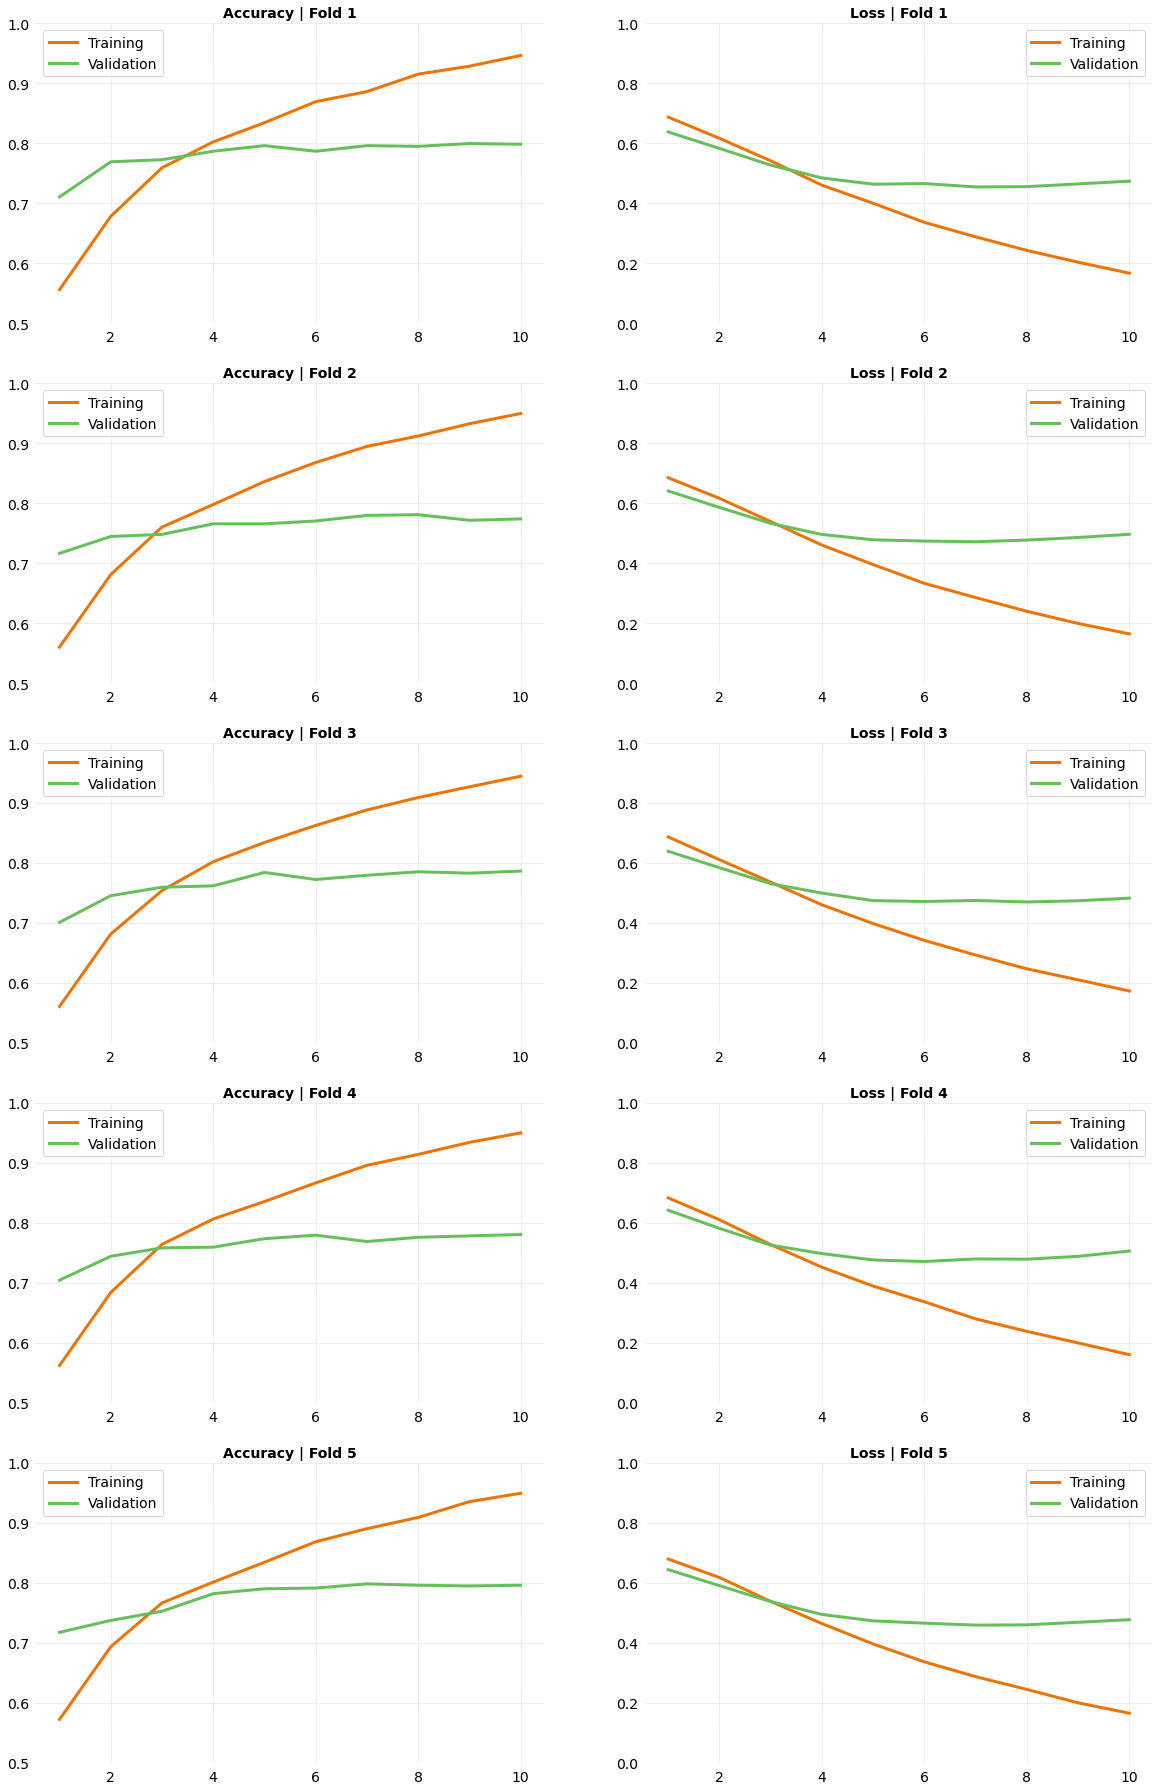

In [ ]:
# Plot Training History
fig = plt.figure(figsize=(20,32))

subplots_pos = [[1,2], [3,4], [5,6], [7,8], [9,10]]

for fold, [si, plot_pos] in enumerate(zip(history_list, subplots_pos)):
    
    acc = si.history['accuracy']
    val_acc = si.history['val_accuracy']
    loss = si.history['loss']
    val_loss = si.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.subplot(5, 2, plot_pos[0])
    plt.ylim(.5, 1)
    plt.yticks(fontsize=14)    
    plt.xticks(fontsize=14)
    plt.grid(zorder=0, linewidth=0.5, linestyle='--', color=plot_grey)
    plt.tick_params(axis="both", bottom=False, left=False)
    plt.box(on=None)
    plt.title('Accuracy | Fold {}'.format(fold+1), fontsize=14, fontweight='bold')
    plt.plot(epochs, acc, color=plot_rost, label='Training', linewidth=3)
    plt.plot(epochs, val_acc, color=plot_green, label='Validation', linewidth=3)
    plt.legend(fontsize=14)
    
    plt.subplot(5, 2, plot_pos[1])
    plt.ylim(0, 1)
    plt.yticks(fontsize=14)    
    plt.xticks(fontsize=14)
    plt.grid(zorder=0, linewidth=0.5, linestyle='--', color=plot_grey) # Alpha
    plt.tick_params(axis="both", bottom=False, left=False)
    plt.box(on=None)
    plt.title('Loss | Fold {}'.format(fold+1), fontsize=14, fontweight='bold')
    plt.plot(epochs, loss, color=plot_rost, label='Training', linewidth=3)
    plt.plot(epochs, val_loss, color=plot_green, label='Validation', linewidth=3)
    plt.legend(fontsize=14)
    
#plt.savefig('./SentencePolarity_CNN_word_history.png', dpi=500, transparent=False, bbox_inches='tight')
plt.show()